<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="500" height="auto" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>Chair of Soil Mechanics and Foundation Engineering<br>Geotechnical Institute<br>Technische Universität Bergakademie Freiberg.</p>
        <p><a href="https://tu-freiberg.de/en/soilmechanics">https://tu-freiberg.de/en/soilmechanics</a></p>
    </div>
</div>

# Kinematische Elemente Methode und Überlegungen zu Sicherheitsfaktoren

Hier werden aus starren Teilkörpern zusammengesetzte Bruchmechanismen betrachtet, die entlang gemeinsamer Gleitfugen translatorisch aneinander abgleiten. Rotationen werden also nicht betrachtet, das Momentengleichgewicht nicht eingefordert (Nachteil). Kleinere kinematische Inkompatibilitäten (Zwängungen) an den Kanten werden ebenso vernachlässigt. Vorteilhaft ist dennoch die Vielfältigkeit des Verfahrens, mit dem realistischere Bruchmechanismen erfasst werden können. Das Verfahren ist ein Beispiel für die Verwendung zusammengesetzter Bruchmechanismen mit geraden Gleitlinien (DIN 4084). Die Lösung kann durch Aufstellen einer Matrizengleichung für das Gesamtsystem erreicht werden. Aus didaktischen Gründen wird hier jedoch elementweise vorgegangen.

In [1]:
#HIDDEN
import numpy as np #numerical methods
import matplotlib.pyplot as plt #plotting
import pandas as pd
import scipy as scp
from scipy import optimize

#Some plot settings
import plot_functions.plot_settings
%run plot_functions/KEM_plots.ipynb

Wir definieren zunächst die Geometrie des Problems, legen also die kinematischen Elemente des Bruchmechanismus fest.

In [2]:
geometry = pd.DataFrame(np.array([[1,2,3,4,5,6,7,8,9],
                                  [6.9,5.5,4.63,5.88,4.6,3.78,2.5,2.36,0.0],
                                  [4.0,4.0,2.84,1.68,-0.2,1.71,0.0,-1.1,0.0]]).T,
                   columns=['Pkt', 'x / m', 'y / m'])
geometry

,Pkt,x / m,y / m
0,1.0,6.90,4.00
1,2.0,5.50,4.00
2,3.0,4.63,2.84
3,4.0,5.88,1.68
4,5.0,4.60,-0.20
5,6.0,3.78,1.71
6,7.0,2.50,0.00
7,8.0,2.36,-1.10
8,9.0,0.00,0.00


In [3]:
#Achtung: Nummerierung im Umlaufsinn!
block1 = define_element(geometry,[1,2,3,4])
block2 = define_element(geometry,[4,3,6,5])
block3 = define_element(geometry,[5,6,7,8])
block4 = define_element(geometry,[8,7,9])
block1

,Pkt,x / m,y / m
0,1.0,6.90,4.00
1,2.0,5.50,4.00
2,3.0,4.63,2.84
3,4.0,5.88,1.68


In [4]:
pd.DataFrame(block1.iloc[0])
pd.concat([block1,pd.DataFrame(block1.iloc[0]).T],ignore_index=True)

,Pkt,x / m,y / m
0,1.0,6.90,4.00
1,2.0,5.50,4.00
2,3.0,4.63,2.84
3,4.0,5.88,1.68
4,1.0,6.90,4.00


In der Darstellung ergibt sich folgende Böschungsgeometrie.

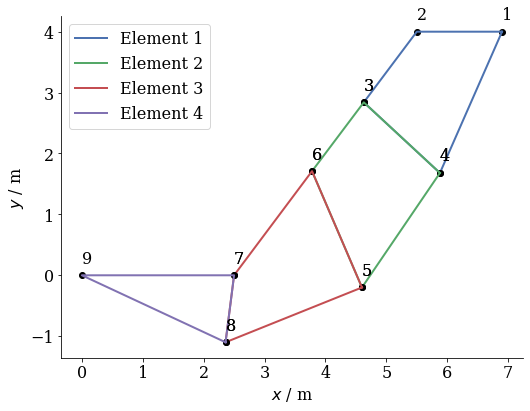

In [5]:
plot_blocks([block1,block2,block3,block4])

## Kinematik, Geschwindigkeitsplan

Zunächst betrachten wir die (vereinfachte) Kinematik des Systems und ermitteln den Geschwindigkeitsplan. Alle Geschwindigkeiten sind determiniert, sobald die Geschwindigkeit eines Körpers vorgegeben wird. Das System hat also einen Freiheitsgrad. Die Bewegungsrichtung der einzelnen Gleitkörper sei durch die Gleitfugen vorgegeben. Mit dieser Information lässt sich also der Geschwindigkeitsplan zeichnen, aus dem sich dann auch die Wirkungsrichtung von Kohäsions- und Reibungskräften in den Gleitfugen ablesen lässt.

![KEM.png](https://raw.githubusercontent.com/nagelt/Teaching_Scripts/master/Images/KEM.png)
[Bild aus: Kolymbas (2016). Geotechnik. Springer Vieweg.]

Geben wir also ohne Einschränkung der Allgemeinheit $\vec{v}_{1}$ so vor, dass $|\vec{v}_{1}| = 1\,$m/s gilt. Die gleitfugenparallelen Geschwindigkeiten $\vec{v}_{2}$, $\vec{v}_{3}$ und $\vec{v}_{4}$ kennen wir zunächst nur der Richtung nach. $\vec{v}_i$ bezeichnet dabei die Bewegung des $i$-ten Gleitkörpers relativ zum unbewegten Teil des betrachteten Bodenkörpers.

In [6]:
v_1 = line_of_Q(geometry, np.eye(2),1,4)
e_v2 = line_of_Q(geometry, np.eye(2),4,5)
e_v3 = line_of_Q(geometry, np.eye(2),5,8)
e_v4 = line_of_Q(geometry, np.eye(2),8,9)

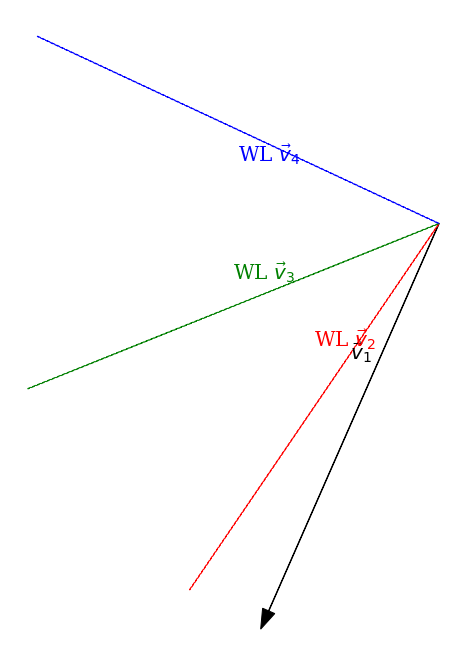

In [7]:
#HIDDEN
scale = 0.3
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=v_1,label='$\\vec{v}_{1}$',scale=scale)
#
line_from_by(ax,delta=e_v2,scale=1,ls='--',label='WL ${\\vec{v}_{2}}$',col='red')
line_from_by(ax,delta=e_v3,scale=1,ls='--',label='WL ${\\vec{v}_{3}}$',col='green')
line_from_by(ax,delta=e_v4,scale=1,ls='--',label='WL ${\\vec{v}_{4}}$',col='blue')
#
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

Die Länge der Vektoren ergibt sich nun daraus, dass die Relativbewegung zweier Körper wiederum durch die gemeinsame Gleitfuge vorgegeben ist. Die Schnittpunkte der Wirkungslinien bestimmen die Beträge der Relativgeschwindigkeiten (Maßstab beachten). Dabei verwenden wir die Notation $\vec{v}_{ij}$ für die Relativbewegung des Gleitkörpers $i$ in Bezug auf den Gleitkörper $j$:

$$
    \vec{v}_{ij} = \vec{v}_i - \vec{v}_j
$$

In [8]:
e_v12 = line_of_Q(geometry, np.eye(2),3,4)
e_v23 = line_of_Q(geometry, np.eye(2),6,5)
e_v34 = line_of_Q(geometry, np.eye(2),7,8)

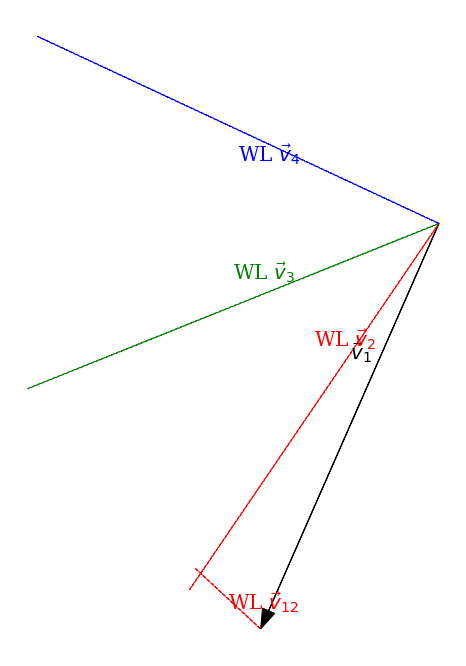

In [9]:
#HIDDEN
scale = 0.3
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=v_1,label='$\\vec{v}_{1}$',scale=scale)
#
line_from_by(ax,delta=e_v2,scale=1,ls='--',label='WL ${\\vec{v}_{2}}$',col='red')
line_from_by(ax,delta=e_v3,scale=1,ls='--',label='WL ${\\vec{v}_{3}}$',col='green')
line_from_by(ax,delta=e_v4,scale=1,ls='--',label='WL ${\\vec{v}_{4}}$',col='blue')
#
line_from_by(ax,fro=v_1,delta=-e_v12,scale=0.2,ls='--',label='WL ${\\vec{v}_{12}}$',col='red')
#line_from_by(ax,delta=e_v56,scale=0.5,ls='--',label='WL ${v_{56}}$')
#line_from_by(ax,delta=e_v78,scale=1,ls='--',label='WL ${v_{78}}$')
#
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

Graphisch können wir uns nun über die jeweiligen Gleitfugenrichtungen von Schnittpunkt zu Schnittpunkt hangeln. Dies entspricht der wiederholten Anwendung der Gleichung

$$
    \vec{v}_{ij} = \vec{v}_i - \vec{v}_j
$$

wobei alle Richtungen bekannt sind, lediglich die Beträge also noch zu bestimmen sind. Wir suchen also statt der Vektoren selbst nur die Skalierungsfaktoren $f_{ij}$ für die Richtungsvektoren $\vec{e}_{ij}$: $\vec{v}_{ij} = f_{ij} \vec{e}_{ij}$.

Mathematisch suchen wir also die Lösung für folgende Gleichungen (6 Gleichungen für 6 Unbekannte):

\begin{align}
    \vec{0} &= f_{2} \vec{e}_{v_{2}} + f_{12} \vec{e}_{v_{12}} - \vec{v}_{1}
    \\
    \vec{0} &= f_{3} \vec{e}_{v_{3}} + f_{23} \vec{e}_{v_{23}} - f_{2} \vec{e}_{v_{2}}
    \\
    \vec{0} &= f_{4} \vec{e}_{v_{4}} + f_{34} \vec{e}_{v_{34}} - f_{3} \vec{e}_{v_{3}}
\end{align}

Wir suchen also die skalaren Faktoren $f_{ij}$, die die Richtungsvektoren $\vec{e}_{v_{ij}}$ so skalieren, dass sich die Geschwindigkeiten gemäß des vorgegebenen Bruchmechanismus addieren.

Wir können nun entweder die Gleichungen nacheinander nach den Unbekannten auflösen, oder alles in ein Gleichungssystem schreiben.

$$
\begin{pmatrix}
    e_{v_{2},x} & e_{v_{12},x} & 0 & 0 & 0 & 0 \\
    e_{v_{2},y} & e_{v_{12},y} & 0 & 0 & 0 & 0 \\
    -e_{v_{2},x} & 0 & e_{v_{3},x} & e_{v_{23},x} & 0 & 0 \\
    -e_{v_{2},y} & 0 & e_{v_{3},y} & e_{v_{23},y} & 0 & 0 \\
    0 & 0 & -e_{v_{3},x} & 0 & e_{v_{4},x} & e_{v_{34},x} \\
    0 & 0 & -e_{v_{3},y} & 0 & e_{v_{4},y} & e_{v_{34},y} \\
    \end{pmatrix}
    \begin{pmatrix}
    f_{2}\\
    f_{12}\\
    f_{3}\\
    f_{23}\\
    f_{4}\\
    f_{34}
    \end{pmatrix}
    =
    \begin{pmatrix}
    v_{1,x}\\
    v_{1,y}\\
    0\\
    0\\
    0\\
    0
    \end{pmatrix}
$$

Man beachte, wie sich die gegebene Information (rechte Seite, $\vec{v}_{14}$) durch die drei Vektorgleichungen fortpflanzt (über die Terme mit Vorzeichenwechsel).

In [10]:
b_v = np.append(v_1,np.zeros((4,1)))
A_v = np.zeros((6,6))
A_v[0:2,0] = e_v2
A_v[0:2,1] = e_v12
#
A_v[2:4,0] = -e_v2
A_v[2:4,2] = e_v3
A_v[2:4,3] = e_v23
#
A_v[4:6,2] = -e_v3
A_v[4:6,4] = e_v4
A_v[4:6,5] = e_v34

In [11]:
f_v = np.linalg.solve(A_v,b_v)

In [12]:
v_2 = f_v[0]*e_v2
v_12 = f_v[1]*e_v12
v_3 = f_v[2]*e_v3
v_23 = f_v[3]*e_v23
v_4 = f_v[4]*e_v4
v_34 = f_v[5]*e_v34

Nun können wir den gesamten Geschwindigkeitsplan zeichnen, und so die Lösung graphisch bestätigen.

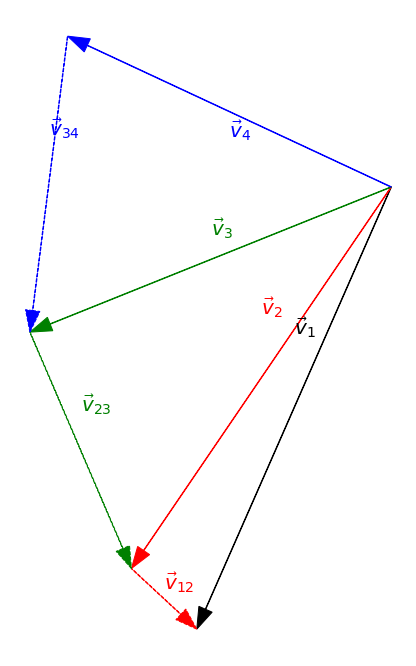

In [13]:
#HIDDEN
scale = 0.3
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=v_1,label='$\\vec{v}_{1}$',scale=scale)
#
vec_from_by(ax,delta=v_2,scale=scale,label='${\\vec{v}_{2}}$',col='red')
vec_from_by(ax,delta=v_3,scale=scale,label='${\\vec{v}_{3}}$',col='green')
vec_from_by(ax,delta=v_4,scale=scale,label='${\\vec{v}_{4}}$',col='blue')
#
vec_from_by(ax,fro=v_2,delta=v_12,scale=scale,label='${\\vec{v}_{12}}$',col='red',ls='--')
vec_from_by(ax,fro=v_3,delta=v_23,scale=scale,label='${\\vec{v}_{23}}$',col='green',ls='--')
vec_from_by(ax,fro=v_4,delta=v_34,scale=scale,label='${\\vec{v}_{34}}$',col='blue',ls='--')
#
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

Das Ergebnis bestätigt nochmals graphisch die Formel

$$
    \vec{v}_{ij} = \vec{v}_i - \vec{v}_j
$$

sowie das intuitive Bild der Bewegungsrichtungen:

![KEM.png](https://raw.githubusercontent.com/nagelt/Teaching_Scripts/master/Images/KEM.png)
[Bild aus: Kolymbas (2016). Geotechnik. Springer Vieweg.]

## Statik, Kräfteplan

Jetzt können wir weitere wesentliche Größen ausrechnen. Genauer gesagt, können wir einen Teil der Einwirkungen und Widerstände bestimmen. Wir beginnen damit, die Gewichtskräfte der einzelnen kinematischen Elemente aus ihren Flächeninhalten ableiten. Zunächst legen wir jedoch die wesentlichen Materialeigenschaften fest.

In [14]:
#Wichte in kN/m³
gamma = 16.
#Kohäsion in kN/m²
c = 5
#Reibungswinkel in rad
phi = np.deg2rad(30)

In [15]:
data = {'A / m²': np.array([block_area(block1),block_area(block2),block_area(block3),block_area(block4)])} #in m

In [16]:
data['G / kN/m'] = data['A / m²']*gamma

In [17]:
blockdata = pd.DataFrame(data)
blockdata

,A / m²,G / kN/m
0,2.85360,45.6576
1,3.19245,51.0792
2,3.09250,49.4800
3,1.37500,22.0000


Am unteren Körper lässt sich direkt das Kräftegleichgewicht konstruieren: Wir kennen die Gewichtskraft sowie die Wirkungslinien der Reibungs- und Kohäsionskräfte in den beiden Gleitfugen. Der Richtungssinn der letzteren beiden Kräfte folgt aus dem Geschwindigkeitsplan. Außerdem sind die Normalenkräfte anzusetzen. Normalkraft $\vec{N}$ und Reibungskraft $\vec{R}$ werden zur Gleitfugenresultierenden $\vec{Q}$ zuammengefasst und aus dem Kräftegleichgewicht bestimmt, während sich die Kohäsionskräfte $\vec{C}$ aus dem Bruchmechanismus ableiten.

## Kräftegleichgewicht am Element 4

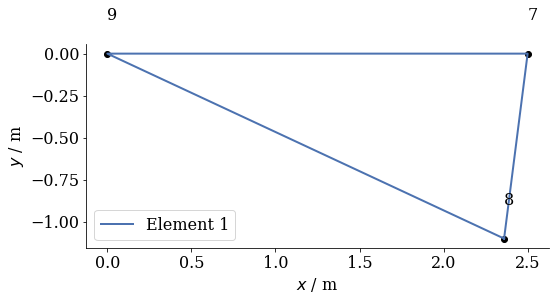

In [18]:
plot_blocks([block4])

Sammeln wir zunächst die aus der Geometrie und den Materialeigenschaften bekannten Vektoren $\vec{G}_4$, $\vec{C}_{4}$ und $\vec{C}_{43}$. Dabei gelte an Grenzflächen die Konvention $\vec{F}_{\text{auf}\,\text{von}}$. Die Wirkrichtung der kohäsiven und Reibanteile ergibt sich aus den Relativgeschwindigkeiten des Geschwindigkeitsplans, so etwa

\begin{align}
    \vec{C}_4 &= - C_4 \vec{e}_{v_4} 
    \\
    \vec{C}_{43} &= - C_{43} \vec{e}_{v_{43}} = C_{43} \vec{e}_{v_{34}}
\end{align}

Die Gravitationskraft pro laufendem Meter ergibt sich aus Wichte und Flächeninhalt des Gleitkörpers. Die Kohäsionskraft pro laufendem Meter folgt aus Kohäsion und Länge der Gleitfuge.

In [19]:
G_4 = gravity_vector(blockdata,4)
G_4

array([  0., -22.])

In [20]:
C_4 = cohesion(c,geometry,9,8)
print("Die Kohäsionskraft beträgt %.2f kN/m" %np.linalg.norm(C_4))
C_4

Die Kohäsionskraft beträgt 13.02 kN/m


array([11.8, -5.5])

In [21]:
C_43 = cohesion(c,geometry,7,8)
print("Die Kohäsionskraft beträgt %.2f kN/m" %np.linalg.norm(C_43))
C_43

Die Kohäsionskraft beträgt 5.54 kN/m


array([-0.7, -5.5])

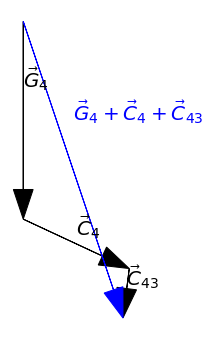

In [22]:
#HIDDEN
scale = np.linalg.norm(G_4)
fig, ax = plt.subplots()
vec_from_by(ax,delta=G_4,label='$\\vec{G}_4$',scale=scale)
vec_from_by(ax,fro=G_4,delta=C_4,label='$\\vec{C}_{4}$',scale=scale)
vec_from_by(ax,fro=G_4+C_4,delta=C_43,label='$\\vec{C}_{43}$',scale=scale)
vec_from_by(ax,delta=G_4+C_4+C_43,label='$\\vec{G}_4 + \\vec{C}_{4} + \\vec{C}_{43}$',scale=scale,col='blue')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

Ausgehend von der Wirkungsrichtung von $\vec{C}_{\text{auf}\,\text{von}}$ ergibt sich die Wirkungsrichtung der Gleitfugenresultierenden $\vec{Q}_{\text{auf}\,\text{von}}$ durch Rotation um $90° - \varphi$ gegen den Uhrzeigersinn (mathematisch positiv) oder im Uhrzeigersinn (mathematisch negativ), da $\vec{Q}$ gegenüber dem Lot auf die Gleitfläche (Wirkungslinie von $\vec{N}$) um den Reibungswinkel $\varphi$ geneigt ist und ebenso wie $\vec{C}$ der Bewegung des Gleitkörpers entgegen wirkt.

Zur Rotation von Vektoren werden Rotationsmatrizen festgelegt.

In [23]:
beta = np.deg2rad(90) - phi
Rp = np.array([[np.cos(beta),-np.sin(beta)],[np.sin(beta),np.cos(beta)]])
Rn = np.array([[np.cos(-beta),-np.sin(-beta)],[np.sin(-beta),np.cos(-beta)]])

In der Darstellung sieht das wie folgt aus:

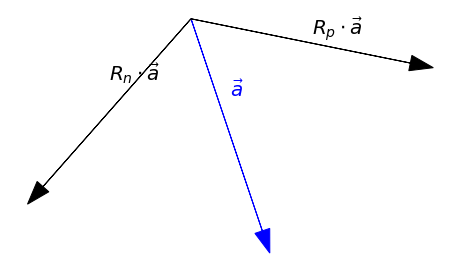

In [24]:
#HIDDEN
scale = np.linalg.norm(G_4)
fig, ax = plt.subplots()
a= G_4+C_4+C_43
vec_from_by(ax,delta=a,label='$\\vec{a}$',scale=scale,col='blue')
vec_from_by(ax,delta=Rp.dot(a),label='$R_p \cdot \\vec{a}$',scale=scale)
vec_from_by(ax,delta=Rn.dot(a),label='$R_n \cdot \\vec{a}$',scale=scale)
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

Nun können wir die Wirkungslinien von $\vec{Q}_{4}$ und $\vec{Q}_{43}$ bestimmen. Diese sind durch die folgenden Einheitsvektoren $\vec{e}_{Q_{4}}$ und $\vec{e}_{Q_{43}}$ gegeben. Für die graphische Lösung benötigen wir natürlich keine Rotationsmatrizen, sondern zeichnen die Wirkungslinien um $\varphi$ gegen das Flächenlot geneigt ein, so dass der Tangentialanteil von $\vec{Q}$ der Relativbewegung zum benachbarten Bodenkörper entgegen wirkt (also parallel zur Kohäsionskraft ist).

In [25]:
e_Q4 = line_of_Q(geometry,Rp,9,8)
e_Q43 = line_of_Q(geometry,Rn,7,8)

Aus dem Schnittpunkt beider Wirkungslinien ergeben sich graphisch die Beträge der gesuchten Kraftvektoren (Zeichenmaßstab beachten!).

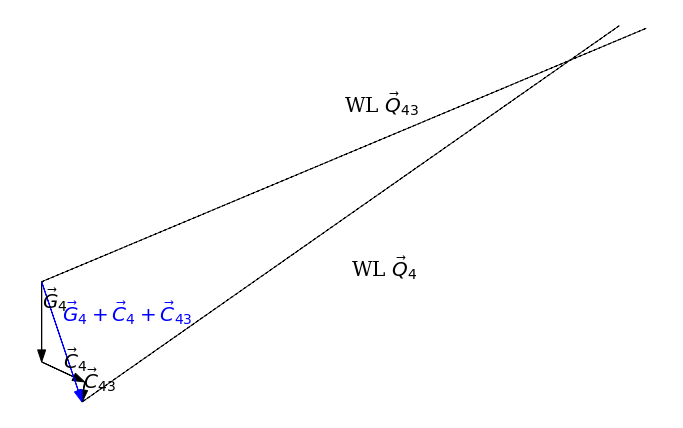

In [26]:
#HIDDEN
scale = np.linalg.norm(G_4)
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=G_4,label='$\\vec{G}_4$',scale=scale)
vec_from_by(ax,fro=G_4,delta=C_4,label='$\\vec{C}_{4}$',scale=scale)
vec_from_by(ax,fro=G_4+C_4,delta=C_43,label='$\\vec{C}_{43}$',scale=scale)
vec_from_by(ax,delta=G_4+C_4+C_43,label='$\\vec{G}_4 + \\vec{C}_{4} + \\vec{C}_{43}$',scale=scale,col='blue')
#
line_from_by(ax,-e_Q43*180,e_Q43,scale=180,ls='--',label='WL ${\\vec{Q}_{43}}$')
line_from_by(ax,G_4+C_4+C_43,e_Q4,scale=180,ls='--',label='WL ${\\vec{Q}_{4}}$')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

Mathematisch gilt es nun wiederum, die Skalierfaktoren $f_i$ zu bestimmen, so dass die Vektorsumme verschwindet, das Krafteck also geschlossen ist und somit das Kräftegleichgewicht als erfüllt gelten kann:

$$
    \vec{0} = \vec{G}_4 + \vec{C}_{4} + \vec{C}_{43} + f_{43} \vec{e}_{Q_{43}} + f_{4} \vec{e}_{Q_{4}}
$$

Somit stehen zwei Gleichungen für die 2 Unbekannten zur Verfügung. Wir stellen die Gleichung in die Form

$$
    A_{ij} f_j = b_i 
$$

um (Sie können auch beide Gleichungen ausschreiben und sie direkt umstellen).

In [27]:
b4 = -(G_4 + C_4 + C_43)

In [28]:
A4 = np.array([e_Q43,e_Q4]).T

In [29]:
f4 = np.linalg.solve(A4,b4)

In [30]:
Q_43 = e_Q43 * f4[0]
print("Die Resultierende beträgt %.2f kN/m" %np.linalg.norm(Q_43))

Die Resultierende beträgt 157.24 kN/m


In [31]:
Q_4 = e_Q4 * f4[1]
print("Die Resultierende beträgt %.2f kN/m" %np.linalg.norm(Q_4))

Die Resultierende beträgt 163.49 kN/m


Mit der graphischen Darstellung des Ergebnisses überprüfen wir, ob wir richtig gerechnet haben.

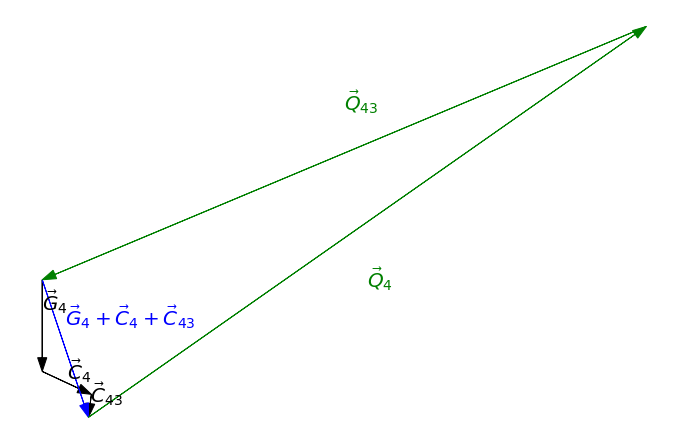

In [32]:
#HIDDEN
scale = np.linalg.norm(G_4)
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=G_4,label='$\\vec{G}_4$',scale=scale)
vec_from_by(ax,fro=G_4,delta=C_4,label='$\\vec{C}_{4}$',scale=scale)
vec_from_by(ax,fro=G_4+C_4,delta=C_43,label='$\\vec{C}_{43}$',scale=scale)
vec_from_by(ax,delta=G_4+C_4+C_43,label='$\\vec{G}_4 + \\vec{C}_{4} + \\vec{C}_{43}$',scale=scale,col='blue')
#
vec_from_by(ax,-Q_43,Q_43,scale=scale,label='${\\vec{Q}_{43}}$',col='green')
vec_from_by(ax,G_4+C_4+C_43,Q_4,scale=scale,label='${\\vec{Q}_{4}}$',col='green')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

## Kräftegleichgewicht an Element 3

Nun, da der Prozess klar ist, wiederholen wir ihn und hangeln uns konzentriert von Element zu Element.

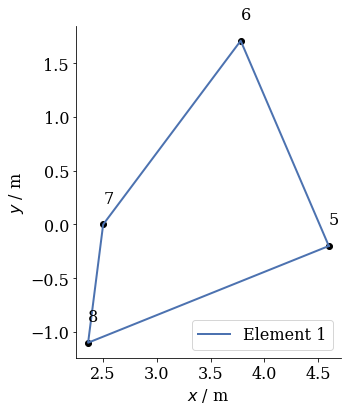

In [33]:
plot_blocks([block3])

Wegen des Schnittprinzips (Kräftegleichgewicht) sind neben der Gewichtskraft bereits folgende Kräfte bekannt: $\vec{C}_{34} = -\vec{C}_{43}$, $\vec{Q}_{34} = - \vec{Q}_{43}$. Daneben können wir die Kohäsionskräfte $\vec{C}_{3}$ und $\vec{C}_{32}$ aus der Geometrie des Gleitkörpers ableiten.

In [34]:
G_3 = gravity_vector(blockdata,3)
C_34 = - C_43
Q_34 = - Q_43

In [35]:
C_3 = cohesion(c,geometry,8,5)
print("Die Kohäsionskraft beträgt %.2f kN/m" %np.linalg.norm(C_3))
C_3

Die Kohäsionskraft beträgt 12.07 kN/m


array([11.2,  4.5])

In [36]:
C_32 = cohesion(c,geometry,6,5)
print("Die Kohäsionskraft beträgt %.2f kN/m" %np.linalg.norm(C_32))
C_32

Die Kohäsionskraft beträgt 10.39 kN/m


array([ 4.1 , -9.55])

Die die Wirkungslinien von $\vec{Q}_{3}$ und $\vec{Q}_{32}$ charakterisierenden Einheitsvektoren bestimmen wir wieder durch Rotation der Wirkungslinien der Kohäsionskräfte.

In [37]:
e_Q3 = line_of_Q(geometry,Rp,8,5)
e_Q32 = line_of_Q(geometry,Rn,6,5)

Das können wir nun graphisch darstellen.

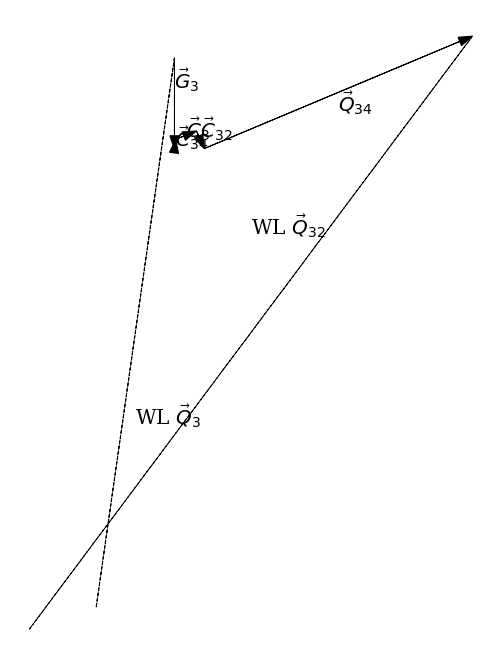

In [38]:
#HIDDEN
scale = np.linalg.norm(G_3)
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=G_3,label='$\\vec{G}_3$',scale=scale)
vec_from_by(ax,fro=G_3,delta=C_34,label='$\\vec{C}_{34}$',scale=scale)
vec_from_by(ax,fro=G_3+C_34,delta=C_3,label='$\\vec{C}_{3}$',scale=scale)
vec_from_by(ax,fro=G_3+C_34+C_3,delta=C_32,label='$\\vec{C}_{32}$',scale=scale)
vec_from_by(ax,fro=G_3+C_34+C_3+C_32,delta=Q_34,label='$\\vec{Q}_{34}$',scale=scale)
#
line_from_by(ax,-e_Q3*300,e_Q3,scale=300,ls='--',label='WL ${\\vec{Q}_{3}}$')
line_from_by(ax,G_3+C_34+C_3+C_32+Q_34,e_Q32,scale=400,ls='--',label='WL ${\\vec{Q}_{32}}$')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

Nun lösen wir wieder folgende Vektorgleichung zur Bestimmung des Schnittpunktes der beiden Wirkungslinien:

$$
    \vec{0} = \vec{G}_3 + \vec{C}_{34} + \vec{C}_{3} + \vec{C}_{32} + \vec{Q}_{34} + f_{3} \vec{e}_{Q_{3}} + f_{32} \vec{e}_{Q_{32}}
$$

In [39]:
b3 = -(G_3 + C_34 + C_3 + C_32 + Q_34)

In [40]:
A3 = np.array([e_Q3,e_Q32]).T

In [41]:
f3 = np.linalg.solve(A3,b3)

In [42]:
Q_3 = e_Q3 * f3[0]
print("Die Resultierende beträgt %.2f kN/m" %np.linalg.norm(Q_3))

Die Resultierende beträgt 254.29 kN/m


In [43]:
Q_32 = e_Q32 * f3[1]
print("Die Resultierende beträgt %.2f kN/m" %np.linalg.norm(Q_32))

Die Resultierende beträgt 328.94 kN/m


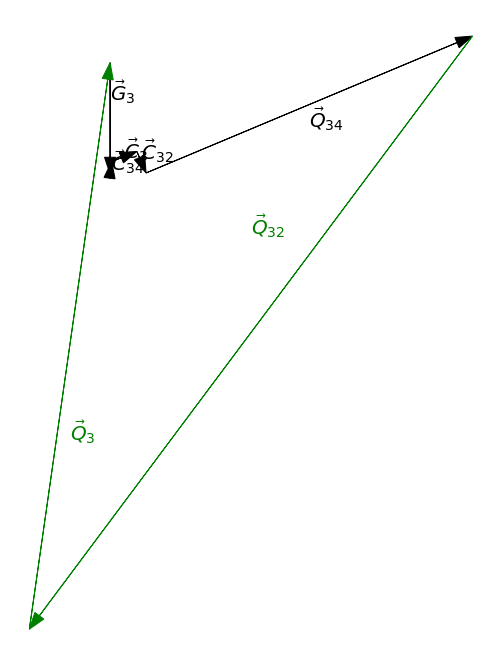

In [44]:
#HIDDEN
scale = np.linalg.norm(G_3)
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=G_3,label='$\\vec{G}_3$',scale=scale)
vec_from_by(ax,fro=G_3,delta=C_34,label='$\\vec{C}_{34}$',scale=scale)
vec_from_by(ax,fro=G_3+C_34,delta=C_3,label='$\\vec{C}_{3}$',scale=scale)
vec_from_by(ax,fro=G_3+C_34+C_3,delta=C_32,label='$\\vec{C}_{32}$',scale=scale)
vec_from_by(ax,fro=G_3+C_34+C_3+C_32,delta=Q_34,label='$\\vec{Q}_{34}$',scale=scale)
#
vec_from_by(ax,-Q_3,Q_3,scale=scale,label='${\\vec{Q}_{3}}$',col='green')
vec_from_by(ax,G_3+C_34+C_3+C_32+Q_34,Q_32,scale=scale,label='${\\vec{Q}_{32}}$',col='green')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

## Kräftegleichgewicht an Element 2

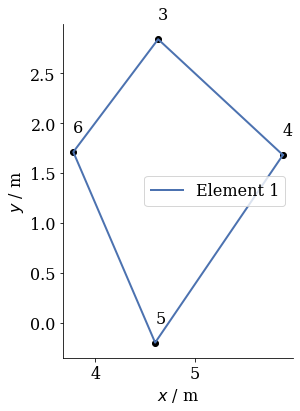

In [45]:
plot_blocks([block2])

Wegen des Schnittprinzips (Kräftegleichgewicht) sind neben der Gewichtskraft bereits folgende Kräfte bekannt: $\vec{C}_{23} = -\vec{C}_{32}$, $\vec{Q}_{23} = - \vec{Q}_{32}$. Daneben können wir die Kohäsionskräfte $\vec{C}_{2}$ und $\vec{C}_{21}$ aus der Geometrie des Gleitkörpers ableiten.

In [46]:
G_2 = gravity_vector(blockdata,2)
C_23 = - C_32
Q_23 = - Q_32

In [47]:
C_2 = cohesion(c,geometry,5,4)
print("Die Kohäsionskraft beträgt %.2f kN/m" %np.linalg.norm(C_2))
C_2

Die Kohäsionskraft beträgt 11.37 kN/m


array([6.4, 9.4])

In [48]:
C_21 = cohesion(c,geometry,3,4)
print("Die Kohäsionskraft beträgt %.2f kN/m" %np.linalg.norm(C_21))
C_21

Die Kohäsionskraft beträgt 8.53 kN/m


array([ 6.25, -5.8 ])

Die die Wirkungslinien von $\vec{Q}_{2}$ und $\vec{Q}_{21}$ charakterisierenden Einheitsvektoren bestimmen wir wieder durch Rotation der Wirkungslinien der Kohäsionskräfte.

In [49]:
e_Q2 = line_of_Q(geometry,Rp,5,4)
e_Q21 = line_of_Q(geometry,Rn,3,4)

Das können wir nun graphisch darstellen.

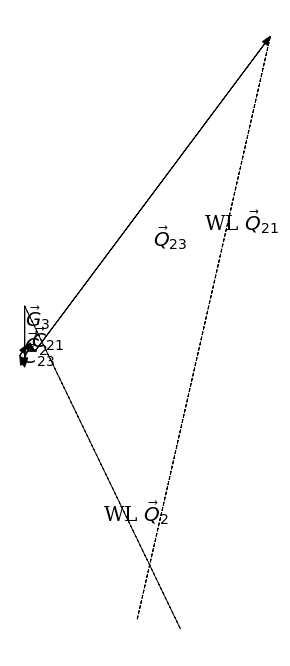

In [50]:
#HIDDEN
scale = np.linalg.norm(G_2)
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=G_2,label='$\\vec{G}_3$',scale=scale)
vec_from_by(ax,fro=G_2,delta=C_23,label='$\\vec{C}_{23}$',scale=scale)
vec_from_by(ax,fro=G_2+C_23,delta=C_2,label='$\\vec{C}_{2}$',scale=scale)
vec_from_by(ax,fro=G_2+C_23+C_2,delta=C_21,label='$\\vec{C}_{21}$',scale=scale)
vec_from_by(ax,fro=G_2+C_23+C_2+C_21,delta=Q_23,label='$\\vec{Q}_{23}$',scale=scale)
#
line_from_by(ax,-e_Q2*300,e_Q2,scale=300,ls='--',label='WL ${\\vec{Q}_{2}}$')
line_from_by(ax,G_2+C_23+C_2+C_21+Q_23,e_Q21,scale=500,ls='--',label='WL ${\\vec{Q}_{21}}$')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

Nun lösen wir wieder folgende Vektorgleichung zur Bestimmung des Schnittpunktes der beiden Wirkungslinien:

$$
    \vec{0} = \vec{G}_2 + \vec{C}_{23} + \vec{C}_{2} + \vec{C}_{21} + \vec{Q}_{23} + f_{2} \vec{e}_{Q_{2}} + f_{21} \vec{e}_{Q_{21}}
$$

In [51]:
b2 = -(G_2 + C_23 + C_2 + C_21 + Q_23)

In [52]:
A2 = np.array([e_Q2,e_Q21]).T

In [53]:
f2 = np.linalg.solve(A2,b2)

In [54]:
Q_2 = e_Q2 * f2[0]
print("Die Resultierende beträgt %.2f kN/m" %np.linalg.norm(Q_2))

Die Resultierende beträgt 240.47 kN/m


In [55]:
Q_21 = e_Q21 * f2[1]
print("Die Resultierende beträgt %.2f kN/m" %np.linalg.norm(Q_21))

Die Resultierende beträgt 453.56 kN/m


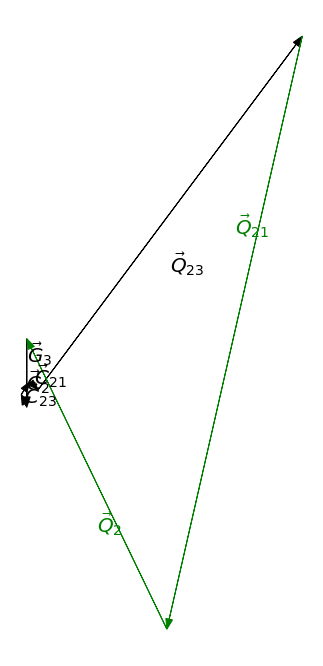

In [56]:
#HIDDEN
scale = np.linalg.norm(G_2)
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=G_2,label='$\\vec{G}_3$',scale=scale)
vec_from_by(ax,fro=G_2,delta=C_23,label='$\\vec{C}_{23}$',scale=scale)
vec_from_by(ax,fro=G_2+C_23,delta=C_2,label='$\\vec{C}_{2}$',scale=scale)
vec_from_by(ax,fro=G_2+C_23+C_2,delta=C_21,label='$\\vec{C}_{21}$',scale=scale)
vec_from_by(ax,fro=G_2+C_23+C_2+C_21,delta=Q_23,label='$\\vec{Q}_{23}$',scale=scale)
#
vec_from_by(ax,-Q_2,Q_2,scale=scale,label='${\\vec{Q}_{2}}$',col='green')
vec_from_by(ax,G_2+C_23+C_2+C_21+Q_23,Q_21,scale=scale,label='${\\vec{Q}_{21}}$',col='green')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

## Kräftegleichgewicht an Element 1

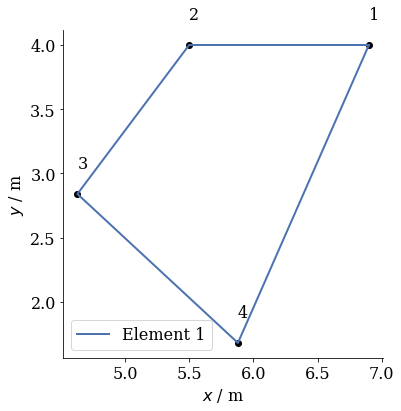

In [57]:
plot_blocks([block1])

Wegen des Schnittprinzips (Kräftegleichgewicht) sind neben der Gewichtskraft bereits folgende Kräfte bekannt: $\vec{C}_{12} = -\vec{C}_{21}$, $\vec{Q}_{12} = - \vec{Q}_{21}$. Daneben können wir die Kohäsionskraft $\vec{C}_{1}$ aus der Geometrie des Gleitkörpers ableiten.

In [58]:
G_1 = gravity_vector(blockdata,1)
C_12 = - C_21
Q_12 = - Q_21

In [59]:
C_1 = cohesion(c,geometry,4,1)
print("Die Kohäsionskraft beträgt %.2f kN/m" %np.linalg.norm(C_1))
C_1

Die Kohäsionskraft beträgt 12.67 kN/m


array([ 5.1, 11.6])

Den die Wirkungslinie von $\vec{Q}_{1}$ charakterisierende Einheitsvektor bestimmen wir wieder durch Rotation der Wirkungslinie der Kohäsionskraft.

In [60]:
e_Q1 = line_of_Q(geometry,Rp,4,1)

Das können wir nun graphisch darstellen.

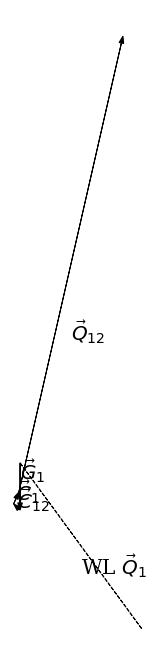

In [61]:
#HIDDEN
scale = np.linalg.norm(G_1)
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=G_1,label='$\\vec{G}_1$',scale=scale)
vec_from_by(ax,fro=G_1,delta=C_12,label='$\\vec{C}_{12}$',scale=scale)
vec_from_by(ax,fro=G_1+C_12,delta=C_1,label='$\\vec{C}_{1}$',scale=scale)
vec_from_by(ax,fro=G_1+C_12+C_1,delta=Q_12,label='$\\vec{Q}_{12}$',scale=scale)
#
line_from_by(ax,-e_Q1*200,e_Q1,scale=200,ls='--',label='WL ${\\vec{Q}_{1}}$')
#line_from_by(ax,G_2+C_56+C_54+C_34+Q_56,e_Q34,scale=500,ls='--',label='WL ${Q_{34}}$')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

Wir sehen, dass sich das Krafteck nicht schließen lässt. Das liegt daran, dass die Widerstände in den Gleitfugen vollständig mobilisiert angesetzt wurden, das System sich aber nicht im Grenzgleichgewicht befindet. Dieses Grenzgleichgewicht führen wir nun künstlich herbei. Zu diesem Zweck wird auf das letzte Element die vertikale Traglast $P_\text{T}$ eingeführt. Sie hat also die Wirkungslinie

$$
    \vec{e}_{P_\text{T}} = \begin{pmatrix} 0\\-1 \end{pmatrix}
$$

Damit zeichnen wir den Kräfteplan erneut.

In [62]:
e_PT = np.array([0,-1])

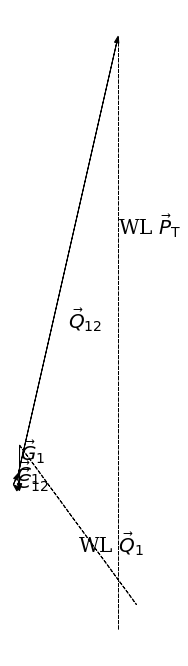

In [63]:
#HIDDEN
scale = np.linalg.norm(G_1)
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=G_1,label='$\\vec{G}_1$',scale=scale)
vec_from_by(ax,fro=G_1,delta=C_12,label='$\\vec{C}_{12}$',scale=scale)
vec_from_by(ax,fro=G_1+C_12,delta=C_1,label='$\\vec{C}_{1}$',scale=scale)
vec_from_by(ax,fro=G_1+C_12+C_1,delta=Q_12,label='$\\vec{Q}_{12}$',scale=scale)
#
line_from_by(ax,-e_Q1*200,e_Q1,scale=200,ls='--',label='WL ${\\vec{Q}_{1}}$')
line_from_by(ax,G_1+C_12+C_1+Q_12,e_PT,scale=600,ls='--',label='WL ${\\vec{P}_\\mathrm{T}}$')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

Nun ergibt sich ein Schnittpunkt. Zur Bestimmung der Traglast, die den gewählten Bruchmechanismus ins Grenzgleichgewicht überführt, lösen wir folgende Vektorgleichung zur Bestimmung des Schnittpunktes der beiden Wirkungslinien:

$$
    \vec{0} = \vec{G}_1 + \vec{C}_{12} + \vec{C}_{1} + \vec{Q}_{12} + f_{1} \vec{e}_{Q_{1}} + f_{P} \vec{e}_{P_\text{T}}
$$

In [64]:
b1 = -(G_1 + C_12 + C_1 + Q_12)

In [65]:
A1 = np.array([e_Q1,e_PT]).T

In [66]:
f1 = np.linalg.solve(A1,b1)

In [67]:
Q_1 = e_Q1 * f1[0]
print("Die Resultierende beträgt %.2f kN/m" %np.linalg.norm(Q_1))

Die Resultierende beträgt 168.72 kN/m


In [68]:
P_T = e_PT * f1[1]
print("Die Traglast, die das System ins Grenzgleichgewicht überführt, beträgt %.2f kN/m" %np.linalg.norm(P_T))

Die Traglast, die das System ins Grenzgleichgewicht überführt, beträgt 549.96 kN/m


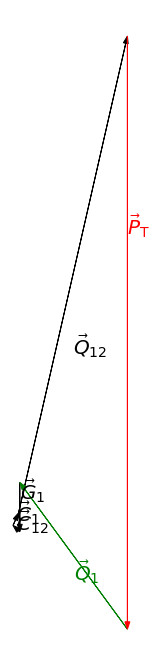

In [69]:
#HIDDEN
scale = np.linalg.norm(G_1)
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=G_1,label='$\\vec{G}_1$',scale=scale)
vec_from_by(ax,fro=G_1,delta=C_12,label='$\\vec{C}_{12}$',scale=scale)
vec_from_by(ax,fro=G_1+C_12,delta=C_1,label='$\\vec{C}_{1}$',scale=scale)
vec_from_by(ax,fro=G_1+C_12+C_1,delta=Q_12,label='$\\vec{Q}_{12}$',scale=scale)
#
vec_from_by(ax,-Q_1,Q_1,scale=scale,label='${\\vec{Q}_{1}}$',col='green')
vec_from_by(ax,G_1+C_12+C_1+Q_12,P_T,scale=scale,label='${\\vec{P}_\\mathrm{T}}$',col='red')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

## Darstellung des Gesamtkräfteplans

Da Kräfte an inneren Gleitfugen sich aufheben (innere Wechselwirkungen), werden im Kräfteplan nur die äußeren Kräfte des Bruchkörpers berücksichtigt. Es ergibt sich folgende Darstellung. Es sei an dieser Stelle nochmals darauf hingewiesen, dass man beim rechnerischen Vorgehen auch direkt das Gesamtgleichungssystem hätte lösen können.

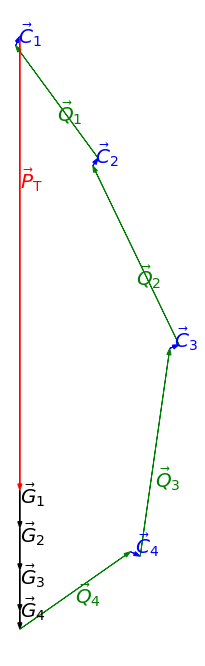

In [70]:
#HIDDEN
scale = np.linalg.norm(G_2)
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=G_1,label='$\\vec{G}_1$',scale=scale)
vec_from_by(ax,fro=G_1,delta=G_2,label='$\\vec{G}_2$',scale=scale)
vec_from_by(ax,fro=G_1+G_2,delta=G_3,label='$\\vec{G}_3$',scale=scale)
vec_from_by(ax,fro=G_1+G_2+G_3,delta=G_4,label='$\\vec{G}_4$',scale=scale)
#
vec_from_by(ax,fro=G_1+G_2+G_3+G_4,delta=Q_4,label='$\\vec{Q}_{4}$',scale=scale,col='green')
vec_from_by(ax,fro=G_1+G_2+G_3+G_4+Q_4,delta=C_4,label='$\\vec{C}_{4}$',scale=scale,col='blue')
vec_from_by(ax,fro=G_1+G_2+G_3+G_4+Q_4+C_4,delta=Q_3,label='$\\vec{Q}_{3}$',scale=scale,col='green')
vec_from_by(ax,fro=G_1+G_2+G_3+G_4+Q_4+C_4+Q_3,delta=C_3,label='$\\vec{C}_{3}$',scale=scale,col='blue')
vec_from_by(ax,fro=G_1+G_2+G_3+G_4+Q_4+C_4+Q_3+C_3,delta=Q_2,label='$\\vec{Q}_{2}$',scale=scale,col='green')
vec_from_by(ax,fro=G_1+G_2+G_3+G_4+Q_4+C_4+Q_3+C_3+Q_2,delta=C_2,label='$\\vec{C}_{2}$',scale=scale,col='blue')
vec_from_by(ax,fro=G_1+G_2+G_3+G_4+Q_4+C_4+Q_3+C_3+Q_2+C_2,delta=Q_1,label='$\\vec{Q}_{1}$',scale=scale,col='green')
vec_from_by(ax,fro=G_1+G_2+G_3+G_4+Q_4+C_4+Q_3+C_3+Q_2+C_2+Q_1,delta=C_1,label='$\\vec{C}_{1}$',scale=scale,col='blue')
#
vec_from_by(ax,fro=G_1+G_2+G_3+G_4+Q_4+C_4+Q_3+C_3+Q_2+C_2+Q_1+C_1,delta=P_T,label='$\\vec{P}_\\mathrm{T}$',scale=scale,col='red')
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

## Variation des Bruchmechanismus und Berechnung von Sicherheitsfaktoren bzw. Ausnutzungsgraden

Im Rahmen des Teilsicherheitskonzeptes werden für die Einwirkungen bzw. die Scherparameter Bemessungswerte angesetzt. Diese werden dann mit Ausnutzungsgraden derart verringert, dass die mobilisierten Scherfestigkeitsparameter *ohne zusätzliche Traglast $\vec{P}_\text{T}$* (in unserem Fall: $\vec{P}_\text{T} = 0$) gerade zum Grenzgleichgewicht führen. Wie bei den bisherigen Verfahren auch, findet hierbei die Felleniusregel Anwendung.

$$
    \tan \varphi_\text{m} = \mu \tan \varphi_\text{d} \qquad c_\text{m} = \mu c_\text{d}
$$

Die Kraft für $\mu = 1$ deckt sich mit der bisherigen Lösung:

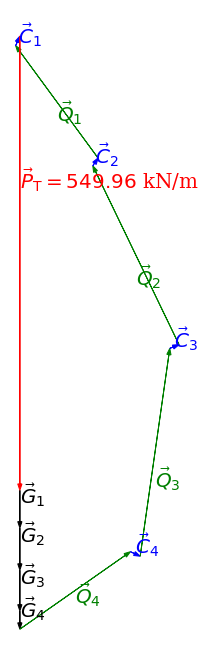

In [71]:
P_T = get_P_T([1],geometry,16,5,30,True)

Nun lässt sich durch Minimierung des Betrags der Traglast $\vec{P}_\text{T}$ der Ausnutzungsgrad bestimmen. Mit anderen Worten reduzieren wir die Widerstände solang, bis sich auch ohne Traglast Grenzgleichgewicht einstellt.

In [72]:
additional = (geometry,16,5,30,False)
res = scp.optimize.root(fun=get_P_T,x0=1.0,args=additional)
eta_v0 = res.x
print("Der Ausnutzungsgrad für den gegebenen Bruchmechanismus ist %.2f. Das liefert eine zusätzliche Traglast von %.2f kN/m" %(res.x,res.fun))

Der Ausnutzungsgrad für den gegebenen Bruchmechanismus ist 0.53. Das liefert eine zusätzliche Traglast von 0.00 kN/m


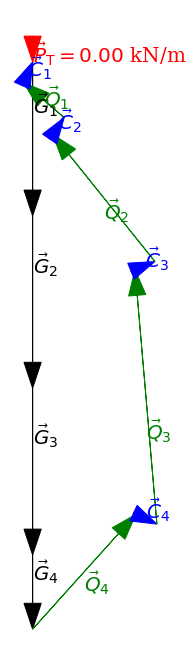

In [73]:
#HIDDEN
P_T = get_P_T(res.x,geometry,16,5,30,True)

Durch Variation des Bruchmechanismus wird nun derjenige als der kritische identifiziert, der den niedrigsten Sicherheitsfaktor liefert. Dazu fassen wir die oben detailliert dargestellte Berechnung in einer Funktion zusammen. Dies sei hier nur exemplarisch dargestellt. Auch diese Variation kann automatisiert werden, was hier jedoch nicht getan wird.

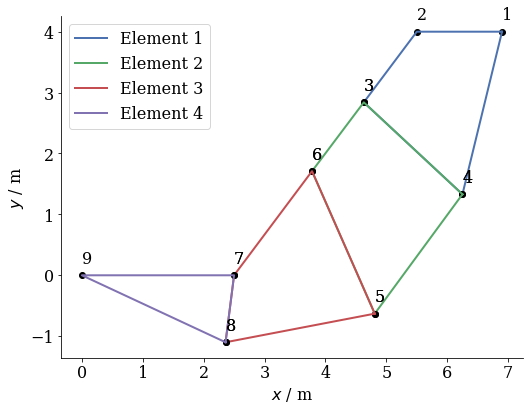

In [74]:
variante1 = pd.DataFrame(np.array([[1,2,3,4,5,6,7,8,9],
                                  [6.9,5.5,4.63,6.25,4.81,3.78,2.5,2.36,0.0],
                                  [4.0,4.0,2.84,1.33,-0.63,1.71,0.0,-1.1,0.0]]).T,
                   columns=['Pkt', 'x / m', 'y / m'])
auto_plot_blocks(variante1)

In [75]:
#HIDDEN
additional = (variante1,16,5,30,False)
res = scp.optimize.root(fun=get_P_T,x0=1.0,args=additional)
eta_v1 = res.x
print("Der Ausnutzungsgrad für den gegebenen Bruchmechanismus ist %.2f. Das liefert eine zusätzliche Traglast von %.2f kN/m" %(res.x,res.fun))

Der Ausnutzungsgrad für den gegebenen Bruchmechanismus ist 0.50. Das liefert eine zusätzliche Traglast von 0.00 kN/m


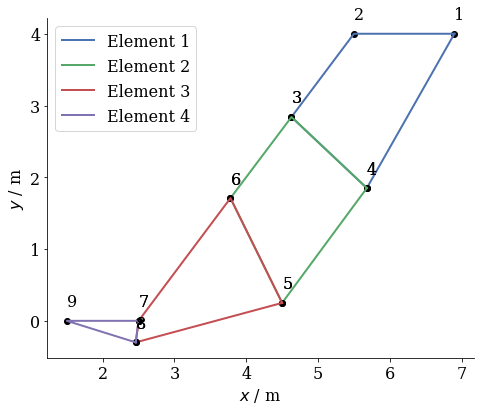

In [76]:
variante2 = pd.DataFrame(np.array([[1,2,3,4,5,6,7,8,9],
                                  [6.9,5.5,4.63,5.68,4.5,3.78,2.5,2.46,1.50],
                                  [4.0,4.0,2.84,1.85,0.25,1.71,0.0,-0.3,0.0]]).T,
                   columns=['Pkt', 'x / m', 'y / m'])
auto_plot_blocks(variante2)

In [77]:
#HIDDEN
additional = (variante2,16,5,30,False)
res = scp.optimize.root(fun=get_P_T,x0=1.0,args=additional)
eta_v2 = res.x
print("Der Ausnutzungsgrad für den gegebenen Bruchmechanismus ist %.2f. Das liefert eine zusätzliche Traglast von %.2f kN/m" %(res.x,res.fun))

Der Ausnutzungsgrad für den gegebenen Bruchmechanismus ist 0.65. Das liefert eine zusätzliche Traglast von 0.00 kN/m


### Sicherheitsfaktoren aus einer Leistungsbilanzierung

Die Festlegung von Sicherheitsfaktoren bzw. Ausnutzungsgraden ist nicht eindeutig. Man könnte auch die Traglast, die den Grenzzustand herbeiführt, ins Verhältnis zu vorhandenen Lasten setzen. Bei unbelasteten Böschungen sollten für eine sinnvolle Definition auch die Gewichtskräfte Berücksichtigung finden.

Eine weitere Methode, den Abstand zum Grenzgleichgewicht zu erfassen, bietet die Bilanzierung der mechanischen Leistung der wirkenden äußeren Lasten (ohne die hypothetische Traglast, die ja gerade das Grenzgleichgewicht herbeiführt) $P_\text{A}$ und der Dissipationsleistung der mobilisierbaren inneren Kräfte (Reibung und Kohäsion) $P_\text{D}$:

$$
    \mu_\text{P} = \frac{P_\text{A}}{P_\text{D}} = \frac{\sum \vec{G}_i \cdot \vec{v}_i}{\sum |\vec{C}_{ij} \cdot \vec{v}_{ij}| + \sum |\vec{Q}_{ij} \cdot \vec{v}_{ij}|}
$$

Mit unterschiedlichen Ansätzen berechnete Sicherheitsfaktoren sind untereinander nicht vergleichbar. Eine vergleichende Bewertung geotechnischer Systeme muss daher auf untereinander konsistenten Definitionen fußen. Nur im Grenzzustand selbst sollten die geeigneten Definitionen alle denselben Wert $\eta = 1$ bzw. $\mu = 1$ liefern. Dies ist für alle hier aufgeführten Definitionen der Fall.

In [78]:
P_A = G_1.dot(v_1) + G_2.dot(v_2) + G_3.dot(v_3) + G_4.dot(v_4)
print("Die Leistung der äußeren Kräfte beträgt %.2f kW /m." %P_A)

Die Leistung der äußeren Kräfte beträgt 90.14 kW /m.


In [79]:
P_D = np.abs((C_1+Q_1).dot(v_1)) + np.abs((C_2+Q_2).dot(v_2)) + np.abs((C_3+Q_3).dot(v_3)) + np.abs((C_4+Q_4).dot(v_4)) + \
    np.abs((C_12+Q_12).dot(v_12)) + np.abs((C_23+Q_23).dot(v_23)) + np.abs((C_34+Q_34).dot(v_34))
print("Die Leistung der inneren Kräfte beträgt %.2f kW /m." %P_D)

Die Leistung der inneren Kräfte beträgt 593.59 kW /m.


In [80]:
print("Der aus der Leistung abgeleitete Ausnutzungsgrad beträgt %.2f" %(P_A/P_D))

Der aus der Leistung abgeleitete Ausnutzungsgrad beträgt 0.15


Wir vergleichen nun noch einmal den Trend der Ergebnisse.

In [81]:
#HIDDEN
print("Die Sicherheitsfaktoren aus der Anwendung der Felleniusregel ergaben für die drei Varianten: %.2f, %.2f, %.2f" %(eta_v0,eta_v1,eta_v2))
print("Die Sicherheitsfaktoren aus der Leistungsbilanzierung ergaben für die drei Varianten: %.2f, %.2f, %.2f" 
      %(get_dissipative_safety(geometry,16,5,30),
        get_dissipative_safety(variante1,16,5,30),
        get_dissipative_safety(variante2,16,5,30)
       )
     )


Die Sicherheitsfaktoren aus der Anwendung der Felleniusregel ergaben für die drei Varianten: 0.53, 0.50, 0.65
Die Sicherheitsfaktoren aus der Leistungsbilanzierung ergaben für die drei Varianten: 0.28, 0.23, 0.46


## Aufgaben

* Variieren Sie Kohäsion und Reibungswinkel. Wie ändern sich die Ergebnisse und warum?
* Variieren Sie die Wichte. Wie ändern sich die Ergebnisse und warum?
* Wie wären Effekte durch anstehendes Grundwasser zu berücksichtigen?